In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.traces_utils.store import TraceStore
from src.models.load import load_base

In [2]:
# Auto-pick latest run in traces/
traces_root = Path("traces")
runs = [p for p in traces_root.iterdir() if p.is_dir() and (p/"meta.json").exists()]
runs = sorted(runs, key=lambda p: p.stat().st_mtime, reverse=True)
run_dir = str(runs[0])
print("Using run:", run_dir)

st = TraceStore(run_dir)
print("meta:", st.meta)
print("arrays:", st.arrays())

tok, model, device = load_base("gpt2")
model.eval()

Using run: traces\20260113-003502_gpt2_csqa_validation_n1200
meta: {'run_id': '20260113-003502_gpt2_csqa_validation_n1200', 'model': 'gpt2', 'arch': 'dec', 'dataset': 'csqa', 'split': 'validation', 'n_examples': 1200, 'max_seq_len': 97, 'num_layers': 12, 'num_heads': 12, 'head_dim': 64, 'dtype': 'float16', 'capture': ['attn', 'qkv', 'hidden', 'resid'], 'has_targets': None, 'time': '2026-01-13 08:54:25'}
arrays: {'dec_self_attn': (1200, 12, 12, 97, 97), 'dec_self_q': (1200, 12, 12, 97, 64), 'dec_self_k': (1200, 12, 12, 97, 64), 'dec_self_v': (1200, 12, 12, 97, 64), 'dec_hidden': (1200, 13, 97, 768), 'dec_res_embed': (1200, 97, 768), 'dec_res_pre_attn': (1200, 12, 97, 768), 'dec_res_post_attn': (1200, 12, 97, 768), 'dec_res_post_mlp': (1200, 12, 97, 768)}


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
choice_labels = ["A", "B", "C", "D", "E"]

choice_token_ids = {}
for lab in choice_labels:
    s = " " + lab
    ids = tok(s, add_special_tokens=False)["input_ids"]
    choice_token_ids[lab] = ids
    print(lab, s, "->", ids, "tokens:", tok.convert_ids_to_tokens(ids))

# using ONLY single-token choices !!!!!!!!!!!!
choice_token_first = {lab: ids[0] for lab, ids in choice_token_ids.items()}
print("choice_token_first:", choice_token_first)


A  A -> [317] tokens: ['ĠA']
B  B -> [347] tokens: ['ĠB']
C  C -> [327] tokens: ['ĠC']
D  D -> [360] tokens: ['ĠD']
E  E -> [412] tokens: ['ĠE']
choice_token_first: {'A': 317, 'B': 347, 'C': 327, 'D': 360, 'E': 412}


In [4]:
# pick an example by id
row0 = st.tokens.iloc[0]
eid = row0["example_id"]
print("example_id:", eid)
print("answerKey:", row0["answerKey"])
print("text preview:\n", row0["text"][:400], "...\n")

enc = st.encodings(eid)
mask = np.array(enc["attention_mask"], dtype=np.int64)
pos = int(mask.sum() - 1)  # last active token position
T = len(enc["input_ids"])
print("T:", T, "mask.sum:", int(mask.sum()), "pos(last):", pos)

Hs = st.hidden(eid, side="dec")  # (L+1, T, D)
print("hidden shape:", Hs.shape)

# prepare weights for logits
W = model.lm_head.weight.detach().to("cpu")  # (vocab, D)
# GPT-2 lm_head has no bias
# logits(token) = h @ W[token].T

layers = Hs.shape[0]  # L+1
print("layers (L+1):", layers)

lab_correct = row0["answerKey"]
id_correct = choice_token_first[lab_correct]
print("correct label:", lab_correct, "token_id:", id_correct)

# collect arrays
layer_logits_5 = []
layer_probs_5  = []
layer_entropy  = []
layer_gap      = []
layer_toplab   = []

for li in range(layers):
    h = torch.tensor(Hs[li, pos, :], dtype=torch.float32)  # (D,)
    logits5 = []
    for lab in choice_labels:
        tid = choice_token_first[lab]
        logits5.append(float(torch.dot(h, W[tid])))
    logits5 = np.array(logits5, dtype=np.float64)  # (5,)

    # softmax over 5 choices
    x = logits5 - logits5.max()
    p = np.exp(x) / np.exp(x).sum()

    # entropy over 5 choices
    ent = float(-(p * np.log(p + 1e-12)).sum())

    # logit gap: correct logit - best other logit
    idx_c = choice_labels.index(lab_correct)
    best_other = np.max(np.delete(logits5, idx_c))
    gap = float(logits5[idx_c] - best_other)

    # top label among A-E
    top_idx = int(np.argmax(logits5))
    toplab = choice_labels[top_idx]

    layer_logits_5.append(logits5)
    layer_probs_5.append(p)
    layer_entropy.append(ent)
    layer_gap.append(gap)
    layer_toplab.append(toplab)

layer_logits_5 = np.stack(layer_logits_5, axis=0)   # (L+1,5)
layer_probs_5  = np.stack(layer_probs_5, axis=0)    # (L+1,5)
layer_entropy  = np.array(layer_entropy)
layer_gap      = np.array(layer_gap)

print("Top labels per layer:", layer_toplab)
print("Final layer top:", layer_toplab[-1])
print("Final P(correct):", float(layer_probs_5[-1, choice_labels.index(lab_correct)]))
print("Final logit gap:", float(layer_gap[-1]))
print("Entropy range:", float(layer_entropy.min()), float(layer_entropy.max()))


example_id: 701fac8b8c04ab56c4394b2e7b2aa8df
answerKey: A
text preview:
 Q: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
Choices:
A: bank
B: library
C: department store
D: mall
E: new york
Answer: ...

T: 97 mask.sum: 54 pos(last): 53
hidden shape: (13, 97, 768)
layers (L+1): 13
correct label: A token_id: 317
Top labels per layer: ['A', 'A', 'A', 'A', 'A', 'D', 'A', 'D', 'B', 'D', 'D', 'D', 'D']
Final layer top: D
Final P(correct): 0.1821488573197599
Final logit gap: -0.9711227416992188
Entropy range: 7.531942010072523e-05 1.5862514863972648


-------------------

# 1. Layerwise probability of the correct answer

Let:

𝐿
 = number of layers


A={A,B,C,D,E} be the answer options


ℓ∈{0,…,L} index layers (including embedding / pre-layer if applicable)

For each layer ℓ, we extract the logits at the final token position and restrict them to the answer-token set A.

then

Let 
𝑧
ℓ
(
𝑎
) denote the logit for answer a∈A at layer ℓ.

compute a restricted softmax over answer options:

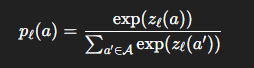

This yields a probability distribution over 
{
𝐴
,
…
,
𝐸
}
 at each layer, conditioned on the full prompt.

----------------

# 2. Layerwise logit gap (decision margin)

Logit gap is defined as : 

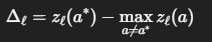

And plotted as : layer_gap = z_correct - z_best_other

!! logits are not transformed via softmax, so the gap reflects raw representational separation instead of a propability.

so the scale is in the logit 'space'

----

# 3. Layerwise entropy over answer options

compute entropy over the answer distribution:

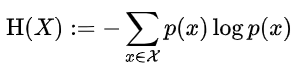

layer_entropy = -np.sum(p * np.log(p), axis=1)

Interpretation

*   High entropy -> uncertainty / indecision

*   Low entropy -> confident commitment to one option

Typical pattern:

*   High entropy in early layers

*   Entropy decreases as layers resolve the answer

*   Final layers show sharp, low-entropy distributions

-----

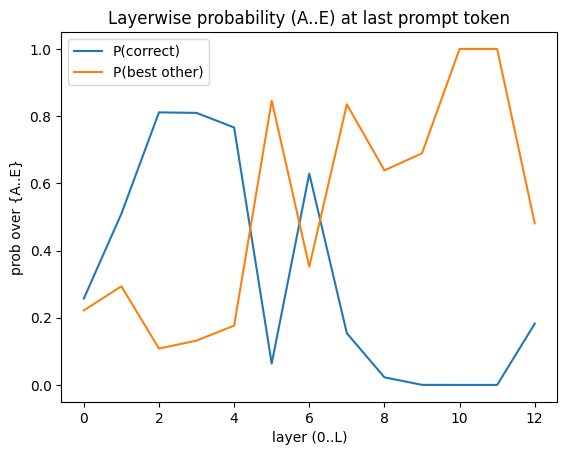

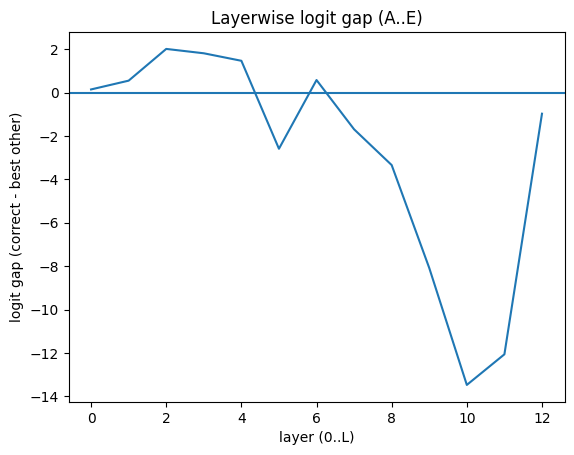

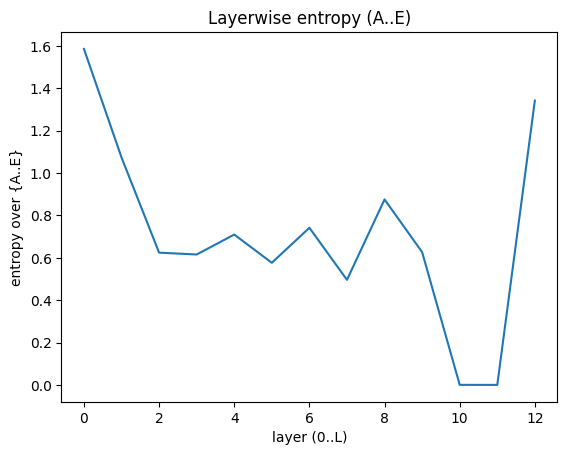

In [5]:
Lp1 = layer_probs_5.shape[0]
x = np.arange(Lp1)

idx_c = choice_labels.index(lab_correct)
p_correct = layer_probs_5[:, idx_c]
p_best_other = np.max(np.delete(layer_probs_5, idx_c, axis=1), axis=1)

plt.figure()
plt.plot(x, p_correct, label="P(correct)")
plt.plot(x, p_best_other, label="P(best other)")
plt.xlabel("layer (0..L)")
plt.ylabel("prob over {A..E}")
plt.title("Layerwise probability (A..E) at last prompt token")
plt.legend()
plt.show()

plt.figure()
plt.plot(x, layer_gap)
plt.axhline(0.0)
plt.xlabel("layer (0..L)")
plt.ylabel("logit gap (correct - best other)")
plt.title("Layerwise logit gap (A..E)")
plt.show()

plt.figure()
plt.plot(x, layer_entropy)
plt.xlabel("layer (0..L)")
plt.ylabel("entropy over {A..E}")
plt.title("Layerwise entropy (A..E)")
plt.show()


N: 1200
L+1: 13
correct_final: 233 wrong_final: 967


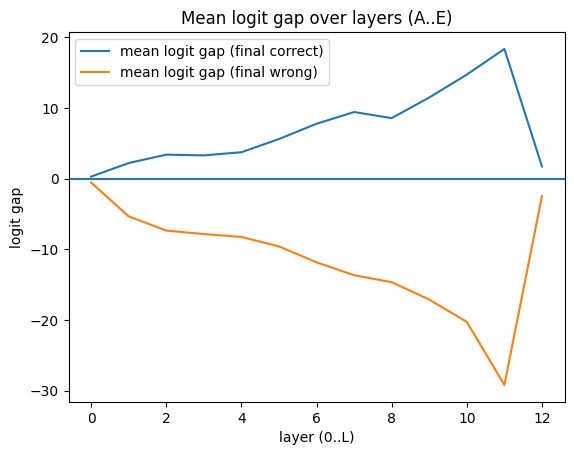

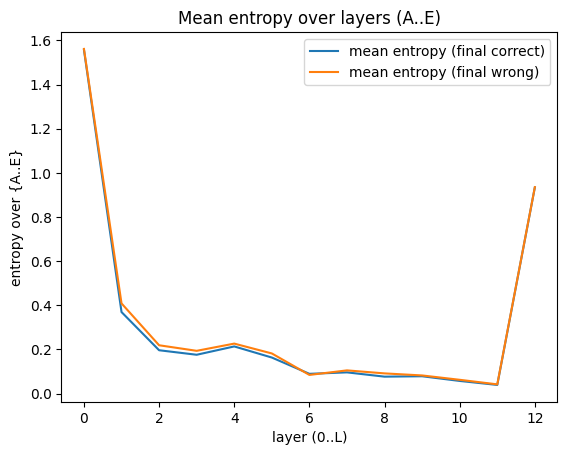

In [6]:
# label an example as "correct_final" if final layer top among A-E == answerKey.
tokens_df = st.tokens.copy().reset_index(drop=True)
N = len(tokens_df)
print("N:", N)

Lp1 = st.arrays()["dec_hidden"][1]  # (N, L+1, T, D) -> L+1
print("L+1:", Lp1)

W = model.lm_head.weight.detach().to("cpu")

mean_gap_correct = np.zeros(Lp1, dtype=np.float64)
mean_gap_wrong   = np.zeros(Lp1, dtype=np.float64)
mean_ent_correct = np.zeros(Lp1, dtype=np.float64)
mean_ent_wrong   = np.zeros(Lp1, dtype=np.float64)

cnt_c = 0
cnt_w = 0

# limit for speed while prototyping
LIMIT = None  # e.g. 200

for i in range(N if LIMIT is None else min(N, LIMIT)):
    row = tokens_df.iloc[i]
    eid = row["example_id"]
    lab_correct = row["answerKey"]

    enc = st.encodings(eid)
    mask = np.array(enc["attention_mask"], dtype=np.int64)
    pos = int(mask.sum() - 1)

    Hs = st.hidden(eid, side="dec")  # (L+1,T,D)

    gaps = []
    ents = []
    tops = []

    for li in range(Lp1):
        h = torch.tensor(Hs[li, pos, :], dtype=torch.float32)
        logits5 = []
        for lab in choice_labels:
            tid = choice_token_first[lab]
            logits5.append(float(torch.dot(h, W[tid])))
        logits5 = np.array(logits5, dtype=np.float64)

        x = logits5 - logits5.max()
        p = np.exp(x) / np.exp(x).sum()

        ent = float(-(p * np.log(p + 1e-12)).sum())
        idx_c = choice_labels.index(lab_correct)
        best_other = np.max(np.delete(logits5, idx_c))
        gap = float(logits5[idx_c] - best_other)

        top = choice_labels[int(np.argmax(logits5))]
        gaps.append(gap)
        ents.append(ent)
        tops.append(top)

    gaps = np.array(gaps)
    ents = np.array(ents)

    correct_final = (tops[-1] == lab_correct)
    if correct_final:
        mean_gap_correct += gaps
        mean_ent_correct += ents
        cnt_c += 1
    else:
        mean_gap_wrong += gaps
        mean_ent_wrong += ents
        cnt_w += 1

print("correct_final:", cnt_c, "wrong_final:", cnt_w)

mean_gap_correct /= max(cnt_c, 1)
mean_gap_wrong   /= max(cnt_w, 1)
mean_ent_correct /= max(cnt_c, 1)
mean_ent_wrong   /= max(cnt_w, 1)

x = np.arange(Lp1)

plt.figure()
plt.plot(x, mean_gap_correct, label="mean logit gap (final correct)")
plt.plot(x, mean_gap_wrong, label="mean logit gap (final wrong)")
plt.axhline(0.0)
plt.xlabel("layer (0..L)")
plt.ylabel("logit gap")
plt.title("Mean logit gap over layers (A..E)")
plt.legend()
plt.show()

plt.figure()
plt.plot(x, mean_ent_correct, label="mean entropy (final correct)")
plt.plot(x, mean_ent_wrong, label="mean entropy (final wrong)")
plt.xlabel("layer (0..L)")
plt.ylabel("entropy over {A..E}")
plt.title("Mean entropy over layers (A..E)")
plt.legend()
plt.show()


-------------------

# Saturation

it is an attempt at quantifing at which layer the model’s predicted answer becomes stable and never changes again up to the final layer.

following *Patience-based Early Exit*  and defining a **saturation (exit) layer**
as the earliest layer where the model’s predicted label stays unchanged for **t consecutive layers**. [:contentReference\[oaicite:1\]{index=1}](https://proceedings.neurips.cc/paper_files/paper/2020/file/d4dd111a4fd973394238aca5c05bebe3-Paper.pdf)

This is the simplest definition presented below :

----------------------

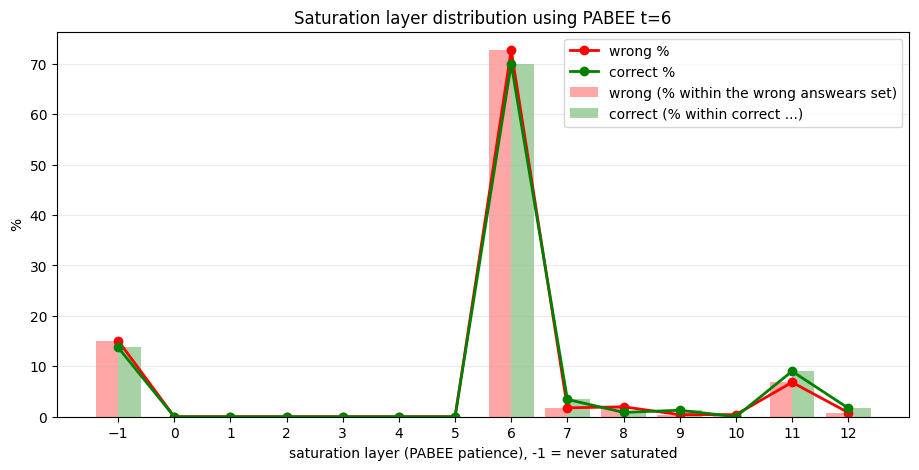

In [16]:
t = 6  #how many consecutive layers with same argmax to declare "saturated"

sat_layers = []
final_correct_flags = []

for i in range(N if LIMIT is None else min(N, LIMIT)):
    row = tokens_df.iloc[i]
    eid = row["example_id"]
    lab_correct = row["answerKey"]

    enc = st.encodings(eid)
    mask = np.array(enc["attention_mask"], dtype=np.int64)
    pos = int(mask.sum() - 1)              # last non-pad token position

    Hs = st.hidden(eid, side="dec")  

    # per-layer top label among {A..E}
    tops = []
    for li in range(Lp1):
        h = torch.tensor(Hs[li, pos, :], dtype=torch.float32)

        logits5 = []
        for lab in choice_labels:
            tid = choice_token_first[lab]  # token id for "A" .. "E" 
            logits5.append(float(torch.dot(h, W[tid])))

        top = choice_labels[int(np.argmax(np.array(logits5)))]
        tops.append(top)

    # patience counter 
    cnt = 0
    sat_layer = -1
    for li in range(Lp1):
        if li == 0:
            cnt = 0
        else:
            cnt = (cnt + 1) if (tops[li] == tops[li-1]) else 0

        # earliest layer where patience is met
        if sat_layer == -1 and cnt >= t:
            sat_layer = li

    sat_layers.append(sat_layer)
    final_correct_flags.append(tops[-1] == lab_correct)

sat_layers = np.array(sat_layers, dtype=int)
final_correct_flags = np.array(final_correct_flags, dtype=bool)

# bins cover -1,0,1,...,Lp1-1
bins = np.arange(-1.5, Lp1 + 0.5, 1)
x = np.arange(-1, Lp1)  # tick centers include -1

sat_correct = sat_layers[final_correct_flags]
sat_wrong   = sat_layers[~final_correct_flags]

cnt_correct, _ = np.histogram(sat_correct, bins=bins)
cnt_wrong,   _ = np.histogram(sat_wrong,   bins=bins)

N_correct = max(1, len(sat_correct))
N_wrong   = max(1, len(sat_wrong))

pct_correct = 100.0 * cnt_correct / N_correct
pct_wrong   = 100.0 * cnt_wrong   / N_wrong

plt.figure(figsize=(11, 5))
plt.bar(x - 0.2, pct_wrong,   width=0.4, color="red",   alpha=0.35, label="wrong (% within the wrong answears set)")
plt.bar(x + 0.2, pct_correct, width=0.4, color="green", alpha=0.35, label="correct (% within correct ...)")
plt.plot(x, pct_wrong,   color="red",   marker="o", linewidth=2, label="wrong %")
plt.plot(x, pct_correct, color="green", marker="o", linewidth=2, label="correct %")

plt.xticks(x)
plt.xlabel("saturation layer (PABEE patience), -1 = never saturated")
plt.ylabel("%")
plt.title(f"Saturation layer distribution using PABEE t={t}")
plt.legend()
plt.grid(True, axis="y", alpha=0.25)
plt.show()



----

# Saturation cdn.

More promissing ways to define saturation:

*   Entropy saturation: output distribution becomes very peaked (low entropy), or the margin between #1 and #2 logits stops increasing.

*   Representation convergence: residual stream stop changing much.https://arxiv.org/pdf/2410.11451

*   Attention saturation: attention weights become near one-hot ( or stable across layers), so later layers mostly “copy the same thing”. https://aclanthology.org/2025.emnlp-main.421.pdf